In [ ]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
! ls ../

Analysis Roadmap.png   binder                 prp
Apr12_presel_2016      boostedhiggs           python
Apr12_presel_2016APV   bootstrap.sh           requirements.txt
Apr12_presel_2017      check_jobs.py          rootfiles
Apr12_presel_2018      condor                 run.py
Feb22_2017             fileset                samples_inclusive.yaml
Mar23_2017             lumi                   samples_vh.yaml
Mar26_2017             new                    setup.md
POG                    pfnano_splitting.yaml  setup.py
README.md              print_parquet.py       setup.sh


In [65]:
! ls ../Apr12_presel_2017

DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to3200                       WJetsToLNu_HT-600To800
QCD_Pt_300to470 

In [66]:
# # counts number of events for a given sample after skimming
# samples_dir = "../Mar23_2017/"
# for sample in os.listdir(samples_dir):
# #     if sample != "SingleMuon_Run2017E":
# #         continue
#     out_files = f"{samples_dir}/{sample}/outfiles/"
#     parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
    
#     if not parquet_files:
#         print(f"No parquet file for {sample}")
#         continue                

#     data = pd.read_parquet(parquet_files)
#     not_empty = len(data) > 0

#     print(f"Finding {len(data)} events for {sample}")

# Read parquets
- loads parquet dataframes and combine different pT-bins per sample
- applies the preselection specefied in the next cell
- saves the combined dataframe under `events[ch][sample]`

In [67]:
presel = {
    "mu": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
#         "invert isolation": "( ( (lep_pt < 55) & (lep_isolation>0.15)) |  (lep_pt >= 55) )",
        
#         "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
#         "invert mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation > 0.2) & (lep_pt >= 55) ) )",

        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )"        
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",
        
    },
    "ele": {
#         ### already applied in processor
#         "isolation": "( ( (lep_pt < 120) & (lep_isolation<0.15)) |  (lep_pt >= 120) )",    
#         "invert isolation": "( ( (lep_pt < 120) & (lep_isolation>0.15)) |  (lep_pt >= 120) )",

        ### checks
#         "lep_fj_dr": "( ( lep_fj_dr>0.03) )"                
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",  
    }    
}

In [130]:
year = "2017"
channels = ["mu", "ele"]
# channels = ["ele"]
samples_dir = "../Mar26_2017"
# samples_dir = f"../Apr12_presel_{year}"

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [131]:
events_dict = utils.event_skimmer(year, channels, samples_dir, samples, presel, "all", add_qcd_score=True, add_top_score=True, add_inclusive_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 37101 events
tot event weight 58944.13282458637 

Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight

Finding QCD_Pt_1800to2400 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 668 events
tot event weight 0.4230152996014006 

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weigh

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 1990 events
tot event weight 2106.016400790356 

Finding HZJ_HToWW_M-125 samples and should combine them under VH
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_isolation_muon weight
Applying weight_id_muon weig

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 795 events
tot event weight 1373.440367316113 

Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the DYJets dataframe with the remaining 22914 events
to

---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
Will fill the WJetsLNu dataframe with the remaining 176703 events
tot event weight 78923.50571055693 

Finding QCD_Pt_470to600 samples and should combine them under QCD
---> Applying preselection.
---> Done with preselection.
---> Accumulating event weights.
Applying weight_genweight weight
Applying weight_L1Prefiring weight
Applying weight_pileup weight
Applying weight_trigger_electron weight
Applying weight_reco_electron weight
Applying weight_id_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
Will fill the QCD dataframe with the remaining 4612 eve

In [209]:
for key in events_dict["ele"]["WJetsLNu"]:
    if "weight" in key:
        print(key)

weight
weight_genweight
weight_L1Prefiring
weight_pileup
weight_trigger_iso_muon
weight_trigger_noniso_muon
weight_isolation_muon
weight_id_muon
weight_id_electron
weight_reco_electron
weight_trigger_electron
weight_vjets_nominal
weight_d1K_NLO
weight_d2K_NLO
weight_d3K_NLO
weight_d1kappa_EW
weight_W_d2kappa_EW
weight_W_d3kappa_EW
event_weight


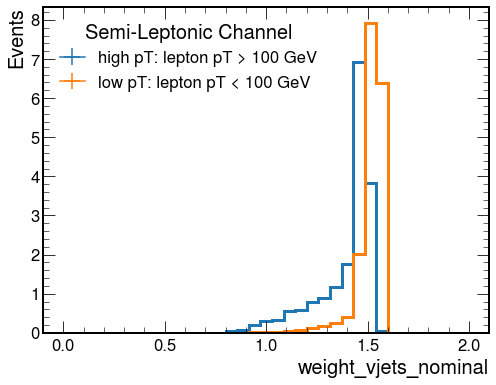

In [187]:
###Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

h = hist2.Hist(
    hist2.axis.Regular(35, 0, 2, name="var", label=r"weight_vjets_nominal", overflow=True),
    hist2.axis.Boolean(name="pT")       
)


for ch in ["ele"]:
    df = events_dict[ch]["WJetsLNu"]
    
    high_pT = df["lep_pt"]>100
    low_pT = ~high_pT
    
    h.fill(
        var=df["weight_vjets_nominal"][high_pT],
        pT=1,
    )
    
    h.fill(
        var=df["weight_vjets_nominal"][low_pT],
        pT=0,
    )

fig, ax = plt.subplots(figsize=(8, 6))

hep.histplot(
    h[{"pT": 1}],
    ax=ax,
    label=r"high pT: lepton pT > 100 GeV",
    linewidth=3,
    density=True
)
hep.histplot(
    h[{"pT": 0}],
    ax=ax,
    label=r"low pT: lepton pT < 100 GeV",
    linewidth=3,
    density=True
)
     
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

In [210]:
events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"]

0         1.495337
1         1.495337
2         1.495337
3         1.495337
4         1.495337
            ...   
176698    1.361580
176699    1.341548
176700    1.495337
176701    1.466088
176702    1.466088
Name: weight_vjets_nominal, Length: 1648422, dtype: float64

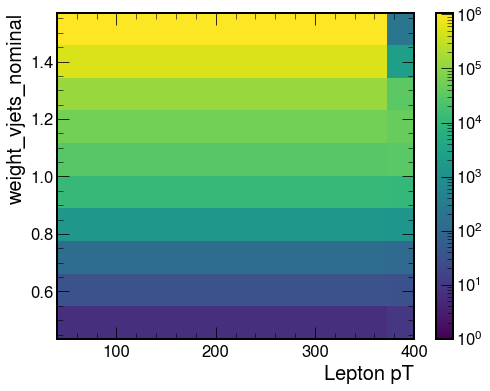

In [138]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist2d(
    events_dict[ch]["WJetsLNu"]["lep_pt"],
    events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"],
    norm=LogNorm(),
    bins=[10,10]
      )
ax.set_xlim(40,400)
ax.set_xlabel("Lepton pT");
ax.set_ylabel("weight_vjets_nominal");
plt.colorbar()

In [ ]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist2d(
    events_dict[ch]["WJetsLNu"]["lep_pt"],
    events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"],
    norm=LogNorm()
      )
ax.set_xlim(40,400)
ax.set_xlabel("Lepton pT");
ax.set_ylabel("weight_vjets_nominal");
plt.colorbar()

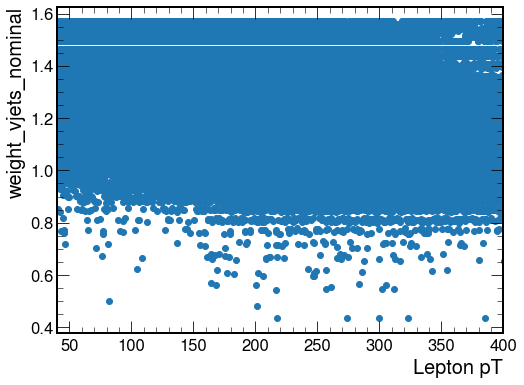

In [234]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    events_dict[ch]["WJetsLNu"]["lep_pt"],
    events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"],
#     norm=LogNorm()
      )
ax.set_xlim(40,400)
ax.set_xlabel("Lepton pT");
ax.set_ylabel("weight_vjets_nominal");
# plt.colorbar()

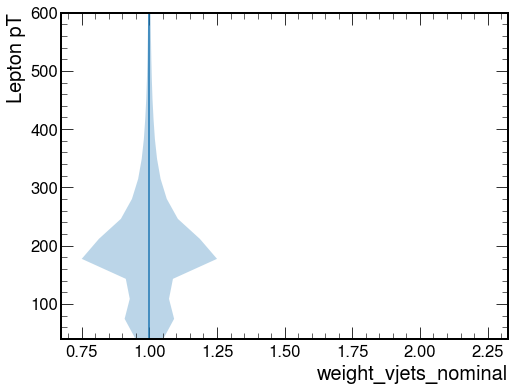

In [254]:


from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))
plt.violinplot([events_dict[ch]["WJetsLNu"]["lep_pt"],events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"]]
              )
# ax.set_xlim(40,400)
ax.set_ylim(40,600)
ax.set_xlabel("weight_vjets_nominal");
ax.set_ylabel("Lepton pT");
# plt.colorbar()

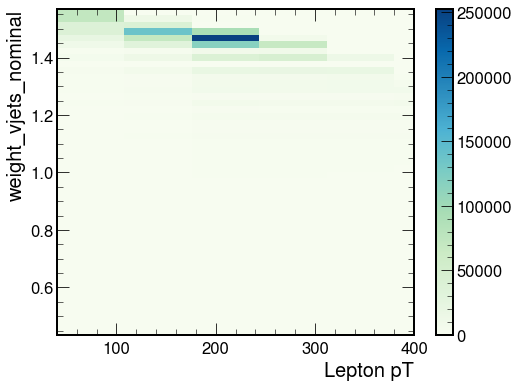

In [244]:
import numpy as np
import matplotlib.pyplot as plt

# Some random data

N = 10000
x = events_dict[ch]["WJetsLNu"]["lep_pt"]
y = events_dict[ch]["WJetsLNu"]["weight_vjets_nominal"]

fig, ax = plt.subplots(figsize=(8, 6))
plt.hist2d(x,y, 50, cmap='GnBu')

ax.set_xlim(40,400)
ax.set_xlabel("Lepton pT");
ax.set_ylabel("weight_vjets_nominal");

plt.colorbar()
plt.show()

In [246]:
def compute_profile(x, y, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

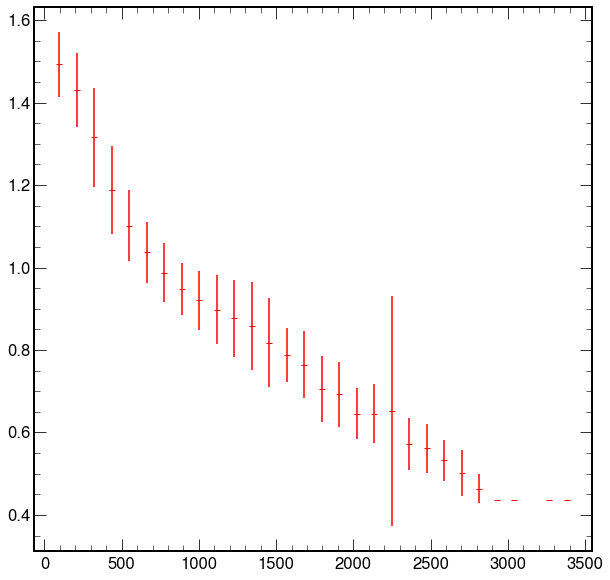

In [247]:
#compute the profile
p_x, p_mean, p_rms = compute_profile(x,y,(30,30))

plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
plt.show()